In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import sys
import random
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras import regularizers


In [ ]:
from google.colab import files

uploaded_file = files.upload()

Saving gutenberg.org_files_16653_16653-0.txt to gutenberg.org_files_16653_16653-0.txt


In [ ]:
uploaded_file1 = files.upload()

Saving weights.hdf5 to weights.hdf5


In [2]:
with open('gutenberg.org_files_16653_16653-0.txt', 'r') as file:
    text = file.read().lower()
print('text length', len(text))

text length 873828


In [3]:
chars = sorted(list(set(text))) # getting all unique chars
print('total chars: ', len(chars))

total chars:  75


In [4]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [5]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ["accuracy"])


# model = Sequential()
# #model.add(Embedding(len(chars), 240, input_shape=(maxlen, len(chars))))
# model.add(Bidirectional(LSTM(150, return_sequences = True)))
# #model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dense(len(chars)/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [10]:
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

callbacks = [print_callback, checkpoint, reduce_lr]

In [14]:
generationText = model.fit(x, y, batch_size=128, epochs=15, callbacks=callbacks)

Epoch 1/15
2276/2276 [==============================] - ETA: 0s - loss: 2.1302 - accuracy: 0.3781
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " skins of animals which
were regarded as"
 skins of animals which
were regarded as of the beat of the cortion and the god the god the beared the mane the rith of the proonted the mere the mond the god the ard of the mand the groded the groment of the ming of the mand the conter and the seated the god the gods of the mather and the sore the the god the eronted the conter and the god the mated the deanted the god and the fored the god the beer and the fore the conter and the the 
----- diversity: 0.5
----- Generating with seed: " skins of animals which
were regarded as"
 skins of animals which
were regarded as were of the hives in the montty ering the mering the magen dith a fored the hish and the laliest of the the deace time to the bean be on in the reane of he the pround conded the indores and her waste

In [15]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [16]:
print(generate_text(500, 0.2))

ll further increased, for the caravan round of the seared in the brother of the seared by the protected to the son of the son of the prosesticial contristed to the sun god of the son of the son of the early and the son of the son of the son of the seared by the sea of the great states of the son of the son of the prosestical of the son of the son of the son of the gods were constroction of the processor egyptian constelled the son of the son of the son of the great for the present the son of the deities were contristing the seared in 


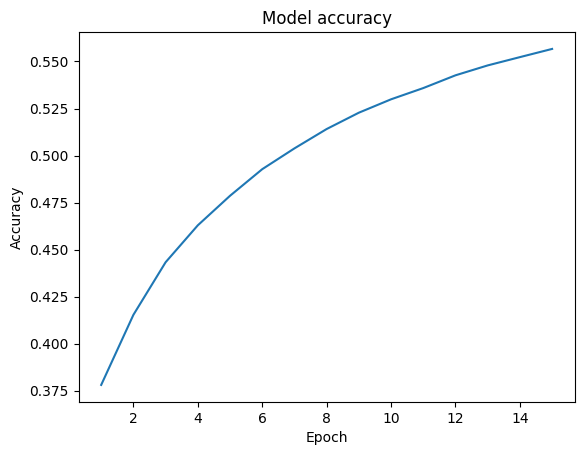

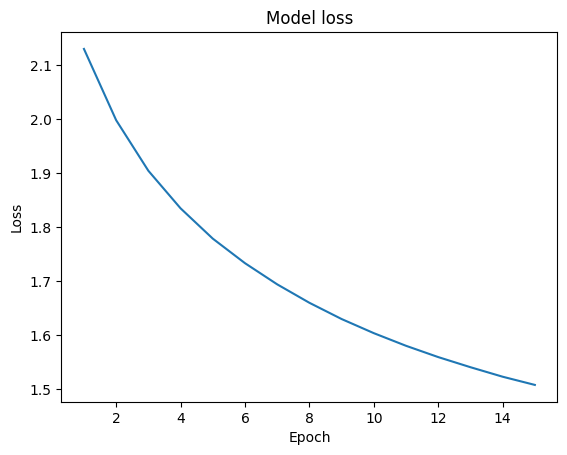

In [17]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
#    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
#   plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
#    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
#    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(generationText, 15)